<h1 align="center">Introduction to SimpleITKv4 Registration - Continued</h1>


## ITK v4 Registration Components 
<img src="ITKv4RegistrationComponentsDiagram.svg" style="width:700px"/><br><br>


Before starting with this notebook, please go over the first introductory notebook found [here](60_Registration_Introduction.ipynb). 

In this notebook we will visually assess registration by viewing the overlap between images using external viewers.
The two viewers we recommend for this task are [ITK-SNAP](http://www.itksnap.org) and [3D Slicer](http://www.slicer.org/). ITK-SNAP supports concurrent linked viewing between multiple instances of the program. 3D Slicer supports concurrent viewing of multiple volumes via alpha blending.

In [1]:
import SimpleITK as sitk

# If the environment variable SIMPLE_ITK_MEMORY_CONSTRAINED_ENVIRONMENT is set, this will override the ReadImage
# function so that it also resamples the image to a smaller size (testing environment is memory constrained).
%run setup_for_testing

# Utility method that either downloads data from the network or
# if already downloaded returns the file name for reading from disk (cached data).
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

# Always write output to a separate directory, we don't want to pollute the source directory. 
import os
OUTPUT_DIR = 'Output'

# GUI components (sliders, dropdown...).
from ipywidgets import interact, fixed
     
# Enable display of HTML.
from IPython.display import display, HTML 
    
# Plots will be inlined.
%matplotlib inline

# Callbacks for plotting registration progress.
import registration_callbacks

## Utility functions
A number of utility functions, saving a transform and corresponding resampled image, callback for selecting a 
DICOM series from several series found in the same directory.

In [2]:
def save_transform_and_image(transform, fixed_image, moving_image, outputfile_prefix):
    """
    Write the given transformation to file, resample the moving_image onto the fixed_images grid and save the
    result to file.
    
    Args:
        transform (SimpleITK Transform): transform that maps points from the fixed image coordinate system to the moving.
        fixed_image (SimpleITK Image): resample onto the spatial grid defined by this image.
        moving_image (SimpleITK Image): resample this image.
        outputfile_prefix (string): transform is written to outputfile_prefix.tfm and resampled image is written to 
                                    outputfile_prefix.mha.
    """                             
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)
    
    # SimpleITK supports several interpolation options, we go with the simplest that gives reasonable results.     
    resample.SetInterpolator(sitk.sitkLinear)  
    resample.SetTransform(transform)
    sitk.WriteImage(resample.Execute(moving_image), outputfile_prefix+'.mha')
    sitk.WriteTransform(transform, outputfile_prefix+'.tfm')
    
def DICOM_series_dropdown_callback(fixed_image, moving_image, series_dictionary):
    """
    Callback from dropbox which selects the two series which will be used for registration.
    The callback prints out some information about each of the series from the meta-data dictionary.
    For a list of all meta-dictionary tags and their human readable names see DICOM standard part 6, 
    Data Dictionary (http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf)
    """
    # The callback will update these global variables with the user selection.
    global selected_series_fixed
    global selected_series_moving
    
    img_fixed = sitk.ReadImage(series_dictionary[fixed_image][0])
    img_moving = sitk.ReadImage(series_dictionary[moving_image][0])
    
    # There are many interesting tags in the DICOM data dictionary, display a selected few.
    tags_to_print = {'0010|0010': 'Patient name: ', 
                     '0008|0060' : 'Modality: ',
                     '0008|0021' : 'Series date: ',
                     '0008|0031' : 'Series time:',
                     '0008|0070' : 'Manufacturer: '}
    html_table = []
    html_table.append('<table><tr><td><b>Tag</b></td><td><b>Fixed Image</b></td><td><b>Moving Image</b></td></tr>')
    for tag in tags_to_print:
        fixed_tag = ''
        moving_tag = ''
        try:            
            fixed_tag = img_fixed.GetMetaData(tag)
        except: # ignore if the tag isn't in the dictionary
            pass
        try:            
            moving_tag = img_moving.GetMetaData(tag)
        except: # ignore if the tag isn't in the dictionary
            pass           
        html_table.append('<tr><td>' + tags_to_print[tag] + 
                          '</td><td>' + fixed_tag + 
                          '</td><td>' + moving_tag + '</td></tr>')
    html_table.append('</table>')
    display(HTML(''.join(html_table)))
    selected_series_fixed = fixed_image
    selected_series_moving = moving_image    

## Loading Data

In this notebook we will work with CT and MR scans of the CIRS 057A multi-modality abdominal phantom. The scans are multi-slice DICOM images. The data is stored in a zip archive which is automatically retrieved and extracted when we request a file which is part of the archive.

In [3]:
data_directory = os.path.dirname(fdata("CIRS057A_MR_CT_DICOM/readme.txt"))

# 'selected_series_moving/fixed' will be updated by the interact function.
selected_series_fixed = ''
selected_series_moving = ''

# Directory contains multiple DICOM studies/series, store the file names
# in dictionary with the key being the series ID.
reader = sitk.ImageSeriesReader()
series_file_names = {}
series_IDs = list(reader.GetGDCMSeriesIDs(data_directory)) #list of all series
            
if series_IDs: #check that we have at least one series
    for series in series_IDs:
        series_file_names[series] = reader.GetGDCMSeriesFileNames(data_directory, series)    
    interact(DICOM_series_dropdown_callback, fixed_image=series_IDs, moving_image =series_IDs, series_dictionary=fixed(series_file_names)); 
else:
    print('This is surprising, data directory does not contain any DICOM series.')

Tag,Fixed Image,Moving Image
Patient name:,test,test
Modality:,CT,CT
Series date:,20140502,20140502
Series time:,131001,131001
Manufacturer:,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS


In [4]:
# Actually read the data based on the user's selection.
fixed_image = sitk.ReadImage(series_file_names[selected_series_fixed])
moving_image = sitk.ReadImage(series_file_names[selected_series_moving])

# Save images to file and view overlap using external viewer.
sitk.WriteImage(fixed_image, os.path.join(OUTPUT_DIR, "fixedImage.mha"))
sitk.WriteImage(moving_image, os.path.join(OUTPUT_DIR, "preAlignment.mha"))

## Initial Alignment

A reasonable guesstimate for the initial translational alignment can be obtained by using
the CenteredTransformInitializer (functional interface to the CenteredTransformInitializerFilter). 

The resulting transformation is centered with respect to the fixed image and the
translation aligns the centers of the two images. There are two options for
defining the centers of the images, either the physical centers
of the two data sets (GEOMETRY), or the centers defined by the intensity 
moments (MOMENTS).

Two things to note about this filter, it requires the fixed and moving image 
have the same type even though it is not algorithmically required, and its
return type is the generic SimpleITK.Transform.

In [6]:
initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image,moving_image.GetPixelID()), 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

# Save moving image after initial transform and view overlap using external viewer.
save_transform_and_image(initial_transform, fixed_image, moving_image, os.path.join(OUTPUT_DIR, "initialAlignment"))

Look at the transformation, what type is it?

In [7]:
print(initial_transform)

itk::simple::Transform
 Euler3DTransform (0x1b79f50)
   RTTI typeinfo:   itk::Euler3DTransform<double>
   Reference Count: 1
   Modified Time: 20924
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1 0 0 
     0 1 0 
     0 0 1 
   Offset: [0, 0, 0]
   Center: [-0.328125, -0.328125, -106.875]
   Translation: [0, 0, 0]
   Inverse: 
     1 0 0 
     0 1 0 
     0 0 1 
   Singular: 0
   Euler's angles: AngleX=0 AngleY=0 AngleZ=0
   m_ComputeZYX = 0



## Final registration

### Version 1
<ul>
<li> Single scale (not using image pyramid).</li>
<li> Initial transformation is not modified in place.</li>
</ul>

<ol>
<li>
Illustrate the need for scaling the step size differently for each parameter:
<ul>
<li> SetOptimizerScalesFromIndexShift - estimated from maximum shift of voxel indexes (only use if data is isotropic).</li>
<li> SetOptimizerScalesFromPhysicalShift - estimated from maximum shift of physical locations of voxels.</li>
<li> SetOptimizerScalesFromJacobian - estimated from the averaged squared norm of the Jacobian w.r.t. parameters.</li>
</ul>
</li>
<li>
Look at the optimizer's stopping condition to ensure we have not terminated prematurely.
</li>
</ol>

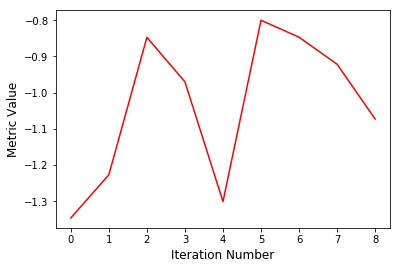

In [8]:
registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
# Scale the step size differently for each parameter, this is critical!!!
registration_method.SetOptimizerScalesFromPhysicalShift() 

registration_method.SetInitialTransform(initial_transform, inPlace=False)

registration_method.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
registration_method.AddCommand(sitk.sitkIterationEvent, 
                               lambda: registration_callbacks.metric_plot_values(registration_method))

final_transform_v1 = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                 sitk.Cast(moving_image, sitk.sitkFloat32))

In [9]:
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))

# Save moving image after registration and view overlap using external viewer.
save_transform_and_image(final_transform_v1, fixed_image, moving_image, os.path.join(OUTPUT_DIR, "finalAlignment-v1"))

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
Final metric value: -1.0545418817048626


Look at the final transformation, what type is it?

In [10]:
print(final_transform_v1)

itk::simple::Transform
 CompositeTransform (0x19009d0)
   RTTI typeinfo:   itk::CompositeTransform<double, 3u>
   Reference Count: 1
   Modified Time: 2989068
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0x25961e0)
     RTTI typeinfo:   itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 2988487
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       1 -3.27282e-05 -0.000140821 
       3.26968e-05 1 -0.000223135 
       0.000140828 0.00022313 1 
     Offset: [0.116343, 1.74431, 0.9241]
     Center: [-0.328125, -0.328125, -106.875]
     Translation: [0.131404, 1.76815, 0.923985]
     Inverse: 
       1 3.26968e-05 0.000140828 
       -3.27282e-05 1 0.00022313 
       -0.000140821 -0.000223135 1 
     Singular: 0
     Euler's angles: AngleX=0.00022313 AngleY=-0.000140828 AngleZ=3.27282e-05
     m_ComputeZYX = 0
   End of MultiTransform.
<<<<<<<<<<
   

### Version 1.1

The previous example illustrated the use of the ITK v4 registration framework in an ITK v3 manner. We only referred to a single transformation which was what we optimized.

In ITK v4 the registration method accepts three transformations (if you look at the diagram above you will only see two transformations, Moving transform represents $T_{opt} \circ T_m$):
<ul>
<li>
SetInitialTransform, $T_{opt}$ - composed with the moving initial transform, maps points from the virtual image domain to the moving image domain, modified during optimization. 
</li>
<li>
SetFixedInitialTransform $T_f$- maps points from the virtual image domain to the fixed image domain, never modified.
</li>
<li>
SetMovingInitialTransform $T_m$- maps points from the virtual image domain to the moving image domain, never modified.
</li>
</ul>

The transformation that maps points from the fixed to moving image domains is thus: $^M\mathbf{p}  = T_{opt}(T_m(T_f^{-1}(^F\mathbf{p})))$

We now modify the previous example to use $T_{opt}$ and $T_m$.

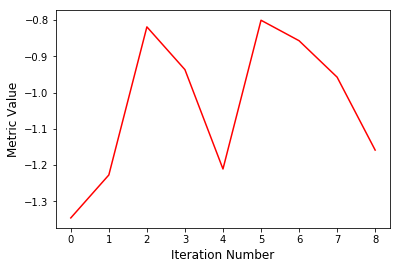

In [11]:
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Set the initial moving and optimized transforms.
optimized_transform = sitk.Euler3DTransform()    
registration_method.SetMovingInitialTransform(initial_transform)
registration_method.SetInitialTransform(optimized_transform)

registration_method.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
registration_method.AddCommand(sitk.sitkIterationEvent, 
                               lambda: registration_callbacks.metric_plot_values(registration_method))

registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                            sitk.Cast(moving_image, sitk.sitkFloat32))

# Need to compose the transformations after registration.
final_transform_v11 = sitk.Transform(optimized_transform)
final_transform_v11.AddTransform(initial_transform)

In [12]:
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))

# Save moving image after registration and view overlap using external viewer.
save_transform_and_image(final_transform_v11, fixed_image, moving_image, os.path.join(OUTPUT_DIR, "finalAlignment-v1.1"))

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
Final metric value: -0.8603736995320468


Look at the final transformation, what type is it? Why is it different from the previous example?

In [13]:
print(final_transform_v11)

itk::simple::Transform
 CompositeTransform (0x18b0d50)
   RTTI typeinfo:   itk::CompositeTransform<double, 3u>
   Reference Count: 1
   Modified Time: 5957237
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0x1730cf0)
     RTTI typeinfo:   itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 5957231
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       1 -0.000433833 -0.000217996 
       0.000433864 1 0.000140411 
       0.000217935 -0.000140506 1 
     Offset: [-0.72222, 4.61237, 1.82938]
     Center: [-0.328125, -0.328125, -106.875]
     Translation: [-0.698779, 4.59722, 1.82936]
     Inverse: 
       1 0.000433864 0.000217935 
       -0.000433833 1 -0.000140506 
       -0.000217996 0.000140411 1 
     Singular: 0
     Euler's angles: AngleX=-0.000140506 AngleY=-0.000217935 AngleZ=0.000433833
     m_ComputeZYX = 0
   >>>>>>>>>
   Euler3DTransform (0

### Version 2

<ul>
<li> Multi scale - specify both scale, and how much to smooth with respect to original image.</li>
<li> Initial transformation modified in place, so in the end we have the same type of transformation in hand.</li>
</ul>

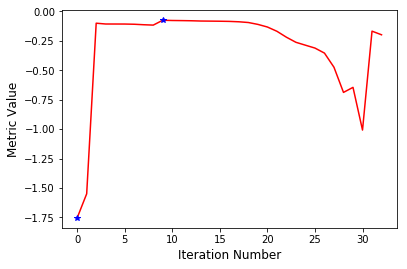

In [ ]:
registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)
   
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100) #, estimateLearningRate=registration_method.EachIteration)
registration_method.SetOptimizerScalesFromPhysicalShift() 

final_transform = sitk.Euler3DTransform(initial_transform)
registration_method.SetInitialTransform(final_transform)
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration_method.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
                               registration_callbacks.metric_update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, 
                               lambda: registration_callbacks.metric_plot_values(registration_method))

registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                            sitk.Cast(moving_image, sitk.sitkFloat32))

In [ ]:
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))

# Save moving image after registration and view overlap using external viewer.
save_transform_and_image(final_transform, fixed_image, moving_image, os.path.join(OUTPUT_DIR, 'finalAlignment-v2'))

Look at the final transformation, what type is it?

In [ ]:
print(final_transform)